# 📘 Ultimate EDA & Feature Engineering Playbook

## Overview
This notebook is a comprehensive guide to Exploratory Data Analysis (EDA) and Feature Engineering.
It is designed to be a **template** you can plug any dataset into.

### 📚 Table of Contents
1. **Environment Setup**: Libraries and Configuration
2. **Data Loading**: Ingestion and Sanity Checks
3. **Initial Exploration**: Structure, Types, and Summary Stats
4. **Data Cleaning**: Missing Values and Duplicates
5. **Univariate Analysis**: Numerical and Categorical Distributions
6. **Bivariate Analysis**: Correlations and Relationships
7. **Multivariate Analysis**: Pairplots and Interactions
8. **Feature Engineering**: Creation, Transformation, and Encoding
9. **Preprocessing**: Scaling and Splitting
10. **Conclusion**: Summary of Findings


## 1. Environment Setup
Importing necessary libraries for manipulation and visualization.


## Configure Your Dataset
Set `DATA_PATH` to a CSV (or leave as `None` to use the synthetic demo). Optionally set `TARGET_COL` and `N_ROWS`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

%matplotlib inline
print('Libraries Imported Successfully')


Libraries Imported Successfully


## 2. Data Loading
Load your dataset here. For this playbook, we will generate a synthetic dataset to demonstrate functionality.


In [2]:
from pathlib import Path
from sklearn.datasets import make_classification

# User options
DATA_PATH = None  # e.g., r"C:\path\to\your.csv"; leave None for synthetic
TARGET_COL = None  # optional: set your target column name
N_ROWS = None      # optional: limit rows when loading
USE_SYNTHETIC_FALLBACK = True


def generate_synthetic() -> pd.DataFrame:
    """Create a messy synthetic binary-class dataset."""
    X, y = make_classification(
        n_samples=1000,
        n_features=20,
        n_informative=10,
        n_redundant=5,
        n_classes=2,
        random_state=42,
    )
    df_syn = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
    df_syn['target'] = y
    df_syn['category_A'] = np.random.choice(['Red', 'Blue', 'Green'], df_syn.shape[0])
    df_syn['category_B'] = np.random.choice(['Low', 'Medium', 'High'], df_syn.shape[0])
    df_syn.loc[::10, 'feature_0'] = np.nan  # inject missing values
    df_syn.loc[::20, 'category_A'] = np.nan
    return df_syn


def load_dataset(data_path=None, target_col=None, n_rows=None, fallback=True):
    df_loaded = None
    resolved_target = target_col

    if data_path:
        try:
            df_loaded = pd.read_csv(Path(data_path), nrows=n_rows)
            print(f'Loaded custom dataset from {data_path} with shape {df_loaded.shape}')
        except FileNotFoundError:
            print(f'File not found at {data_path}. Using fallback: {fallback}.')
        except Exception as e:
            print(f'Failed to load custom dataset: {e}. Using fallback: {fallback}.')

    if df_loaded is None:
        if fallback:
            print('Using synthetic dataset (fallback).')
            df_loaded = generate_synthetic()
            resolved_target = 'target'
        else:
            raise ValueError('No dataset loaded and fallback is disabled.')

    if resolved_target and resolved_target in df_loaded.columns:
        target_col_final = resolved_target
    else:
        candidate_targets = [c for c in ['target', 'label', 'Outcome', 'class', 'y'] if c in df_loaded.columns]
        target_col_final = candidate_targets[0] if candidate_targets else None
        if target_col_final:
            print(f'Inferred target column: {target_col_final}')

    return df_loaded, target_col_final


df, TARGET_COL = load_dataset(DATA_PATH, TARGET_COL, N_ROWS, USE_SYNTHETIC_FALLBACK)
NUM_COLS = df.select_dtypes(include=np.number).columns.tolist()
CAT_COLS = df.select_dtypes(exclude=np.number).columns.tolist()
NUM_EXAMPLE_COLS = NUM_COLS[:4]
CAT_EXAMPLE_COLS = CAT_COLS[:2]
FIRST_NUM_COL = NUM_COLS[0] if NUM_COLS else None
SECOND_NUM_COL = NUM_COLS[1] if len(NUM_COLS) > 1 else None

print(f'Numeric cols: {len(NUM_COLS)}, Categorical cols: {len(CAT_COLS)}, Target: {TARGET_COL}')
df.head()


Using synthetic dataset (fallback).
Numeric cols: 21, Categorical cols: 2, Target: target


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target,category_A,category_B
0,NaN,-0.360450,-0.591602,-0.728228,0.941690,1.065964,0.017832,-0.596184,1.840712,-1.497093,-1.202672,-0.603968,2.899256,0.037567,-1.249523,0.257963,0.416628,1.408208,-1.838041,-0.833142,1,NaN,Low
1,4.513369,-2.227103,-1.140747,2.018263,-2.238358,-0.497370,0.714550,0.938883,-2.395169,0.159837,0.133942,1.461499,3.954171,0.309054,0.538184,-7.157865,-4.532216,-0.081800,-9.325362,0.574386,1,Green,Medium
2,-2.355643,2.218601,-1.603269,0.873394,0.401483,0.717264,-0.859399,-1.042190,-2.175965,0.980231,1.498546,0.544434,-2.466258,-0.470256,0.073018,-2.203531,-2.299263,-1.742761,-0.271579,-0.359285,0,Green,Medium
3,-1.596198,-0.857427,1.772434,-0.639361,1.419409,-0.438525,0.281949,2.345145,1.006230,0.389135,0.238566,-1.025051,-2.422975,1.579807,-0.300713,4.267120,2.893775,1.236697,6.034785,-0.045711,0,Green,Low
4,2.840049,-2.489600,-0.844902,-1.594362,-4.688517,0.459637,0.913607,-1.143505,1.263937,-2.040928,0.675664,4.176424,1.341742,0.133565,1.743819,1.531188,2.269808,0.053489,-3.151109,1.603702,0,Blue,Medium


## 3. Initial Exploration
Understanding the basic structure of the data.


In [3]:
# 3.1 Data Types and Info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   900 non-null    float64
 1   feature_1   1000 non-null   float64
 2   feature_2   1000 non-null   float64
 3   feature_3   1000 non-null   float64
 4   feature_4   1000 non-null   float64
 5   feature_5   1000 non-null   float64
 6   feature_6   1000 non-null   float64
 7   feature_7   1000 non-null   float64
 8   feature_8   1000 non-null   float64
 9   feature_9   1000 non-null   float64
 10  feature_10  1000 non-null   float64
 11  feature_11  1000 non-null   float64
 12  feature_12  1000 non-null   float64
 13  feature_13  1000 non-null   float64
 14  feature_14  1000 non-null   float64
 15  feature_15  1000 non-null   float64
 16  feature_16  1000 non-null   float64
 17  feature_17  1000 non-null   float64
 18  feature_18  1000 non-null   float64
 19  feature_19  1000 non-null   

In [4]:
# 3.2 Summary Statistics (Numerical)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
feature_0,900.0,0.094119,2.120872,-6.865339,-1.314741,0.096858,1.573801,7.021821
feature_1,1000.0,0.018832,2.095132,-7.030162,-1.360239,0.125624,1.410062,8.237993
feature_2,1000.0,-0.480995,1.879645,-6.227178,-1.762233,-0.561960,0.730689,6.903293
feature_3,1000.0,0.020933,2.011018,-6.184692,-1.272814,0.138819,1.459672,6.832418
feature_4,1000.0,0.336366,3.542104,-11.421566,-1.861818,0.302071,2.679576,11.988010
feature_5,1000.0,-0.002051,0.988013,-3.250333,-0.670887,0.015847,0.626378,3.287761
feature_6,1000.0,0.023751,1.011611,-3.375579,-0.659505,0.001733,0.706289,3.428910
feature_7,1000.0,-0.518758,2.104034,-7.771723,-1.842647,-0.537322,0.823834,6.489389
feature_8,1000.0,0.318615,2.955660,-9.055589,-1.612948,0.532299,2.394011,8.443451
feature_9,1000.0,-0.477339,2.050913,-8.705917,-1.857157,-0.423465,1.003092,5.101133


In [5]:
# 3.3 Summary Statistics (Categorical)
df.describe(include=['object']).T


,count,unique,top,freq
category_A,950,3,Green,323
category_B,1000,3,High,353


## 4. Data Cleaning
Identifying and handling Nulls and Duplicates.


In [8]:
# 4.1 Missing Value Analysis
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    missing_percent = (missing / len(df)) * 100
    pd.DataFrame({'Missing Count': missing, 'Percentage': missing_percent})
else:
    print('No missing values found')


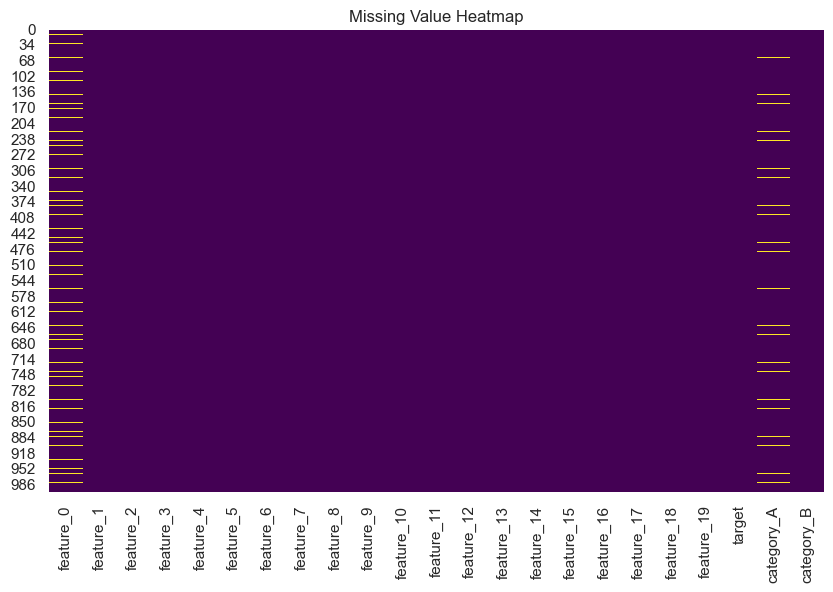

In [9]:
# 4.2 Visualizing Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()


In [10]:
# 4.3 Handling Missing Values
# Strategy: Impute Numerical with Median, Categorical with Mode

# Numerical
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print('Missing values handled.')


Missing values handled.


In [11]:
# 4.4 Duplicate Removal
duplicates = df.duplicated().sum()
print(f'Duplicates found: {duplicates}')
df.drop_duplicates(inplace=True)


Duplicates found: 0


## 5. Univariate Analysis
Analyzing features individually.


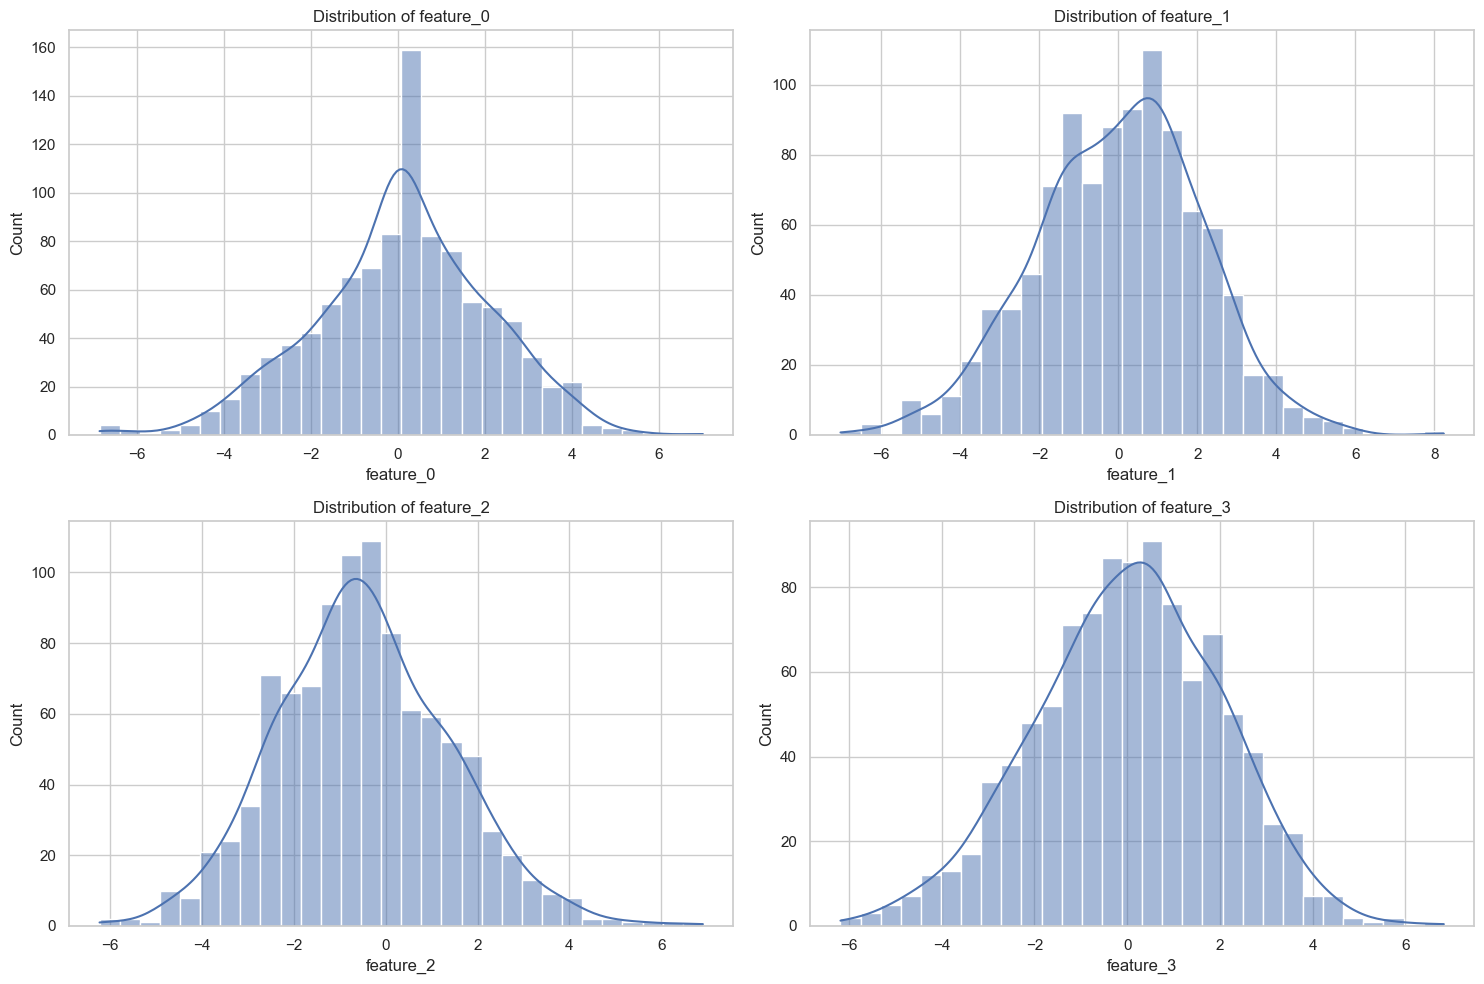

In [12]:
# 5.1 Numerical Distributions (Histograms + KDE)
if not NUM_EXAMPLE_COLS:
    print('No numeric columns to plot.')
else:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(NUM_EXAMPLE_COLS, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


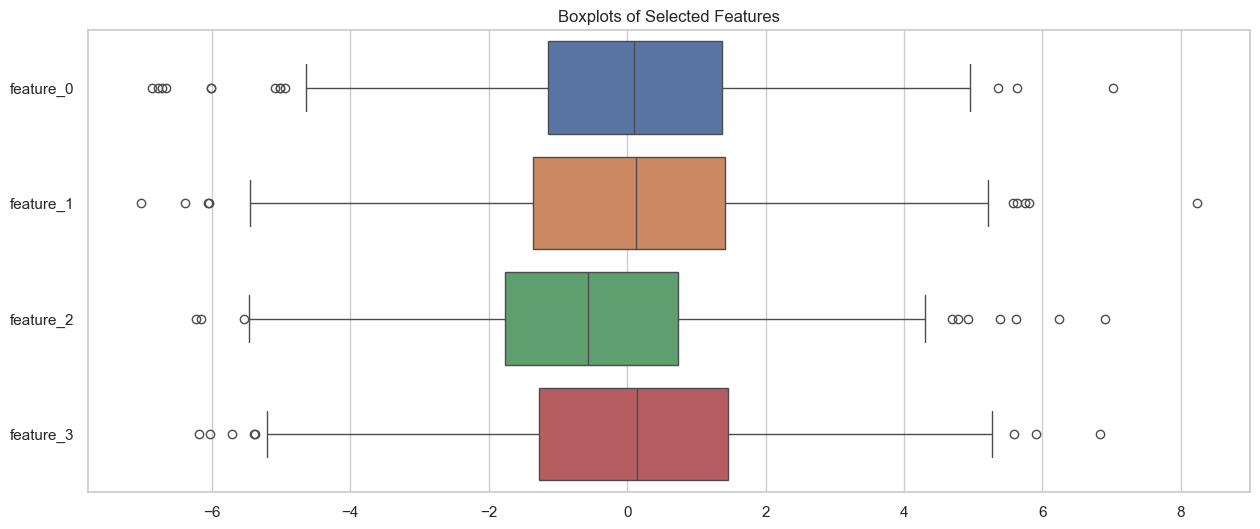

In [13]:
# 5.2 Boxplots for Outlier Detection
if not NUM_EXAMPLE_COLS:
    print('No numeric columns to plot.')
else:
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=df[NUM_EXAMPLE_COLS], orient='h')
    plt.title('Boxplots of Selected Features')
    plt.show()


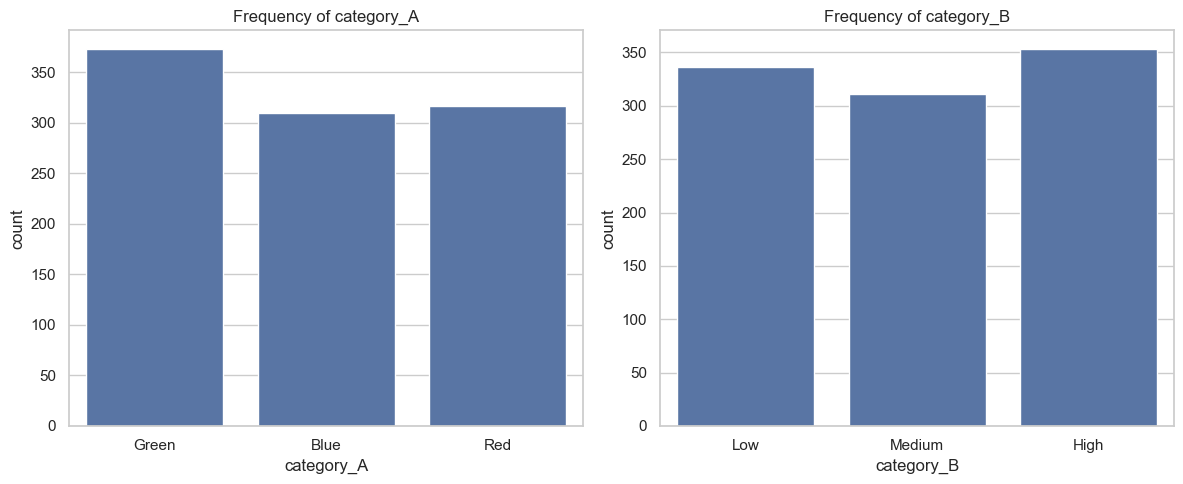

In [14]:
# 5.3 Categorical Frequency Plots
if not CAT_EXAMPLE_COLS:
    print('No categorical columns to plot.')
else:
    n = len(CAT_EXAMPLE_COLS)
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(CAT_EXAMPLE_COLS, 1):
        plt.subplot(1, n, i)
        sns.countplot(x=col, data=df)
        plt.title(f'Frequency of {col}')
    plt.tight_layout()
    plt.show()


## 6. Bivariate Analysis
Analyzing relationships between variables and the target.


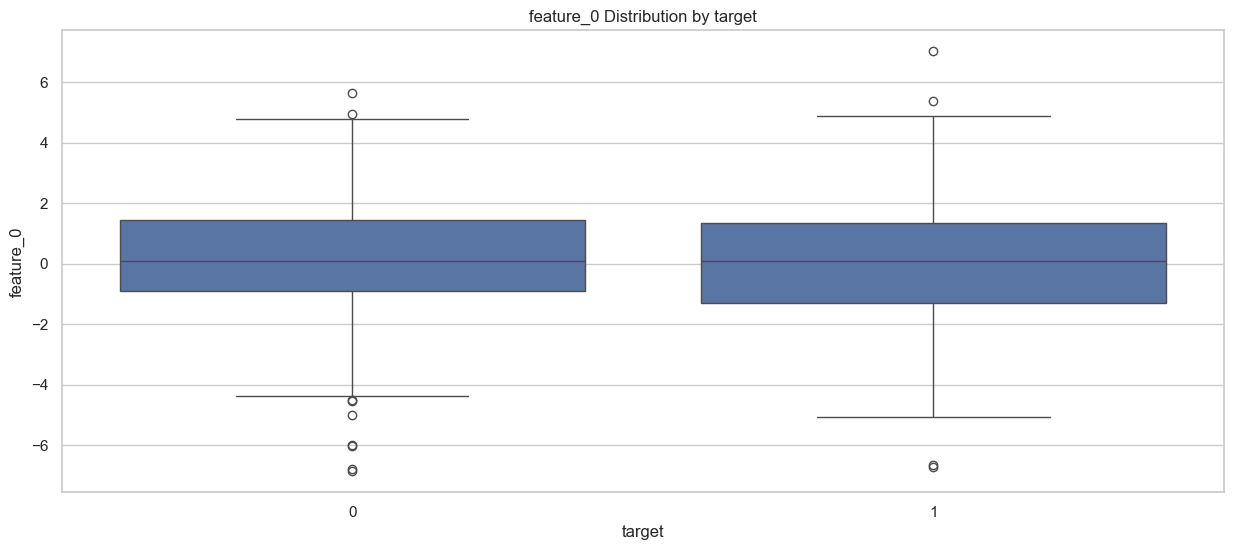

In [15]:
# 6.1 Numerical Feature vs Target (Box Plot)
if TARGET_COL and FIRST_NUM_COL:
    plt.figure(figsize=(15, 6))
    sns.boxplot(x=TARGET_COL, y=FIRST_NUM_COL, data=df)
    plt.title(f'{FIRST_NUM_COL} Distribution by {TARGET_COL}')
    plt.show()
else:
    print('Skip: need TARGET_COL and at least one numeric column.')


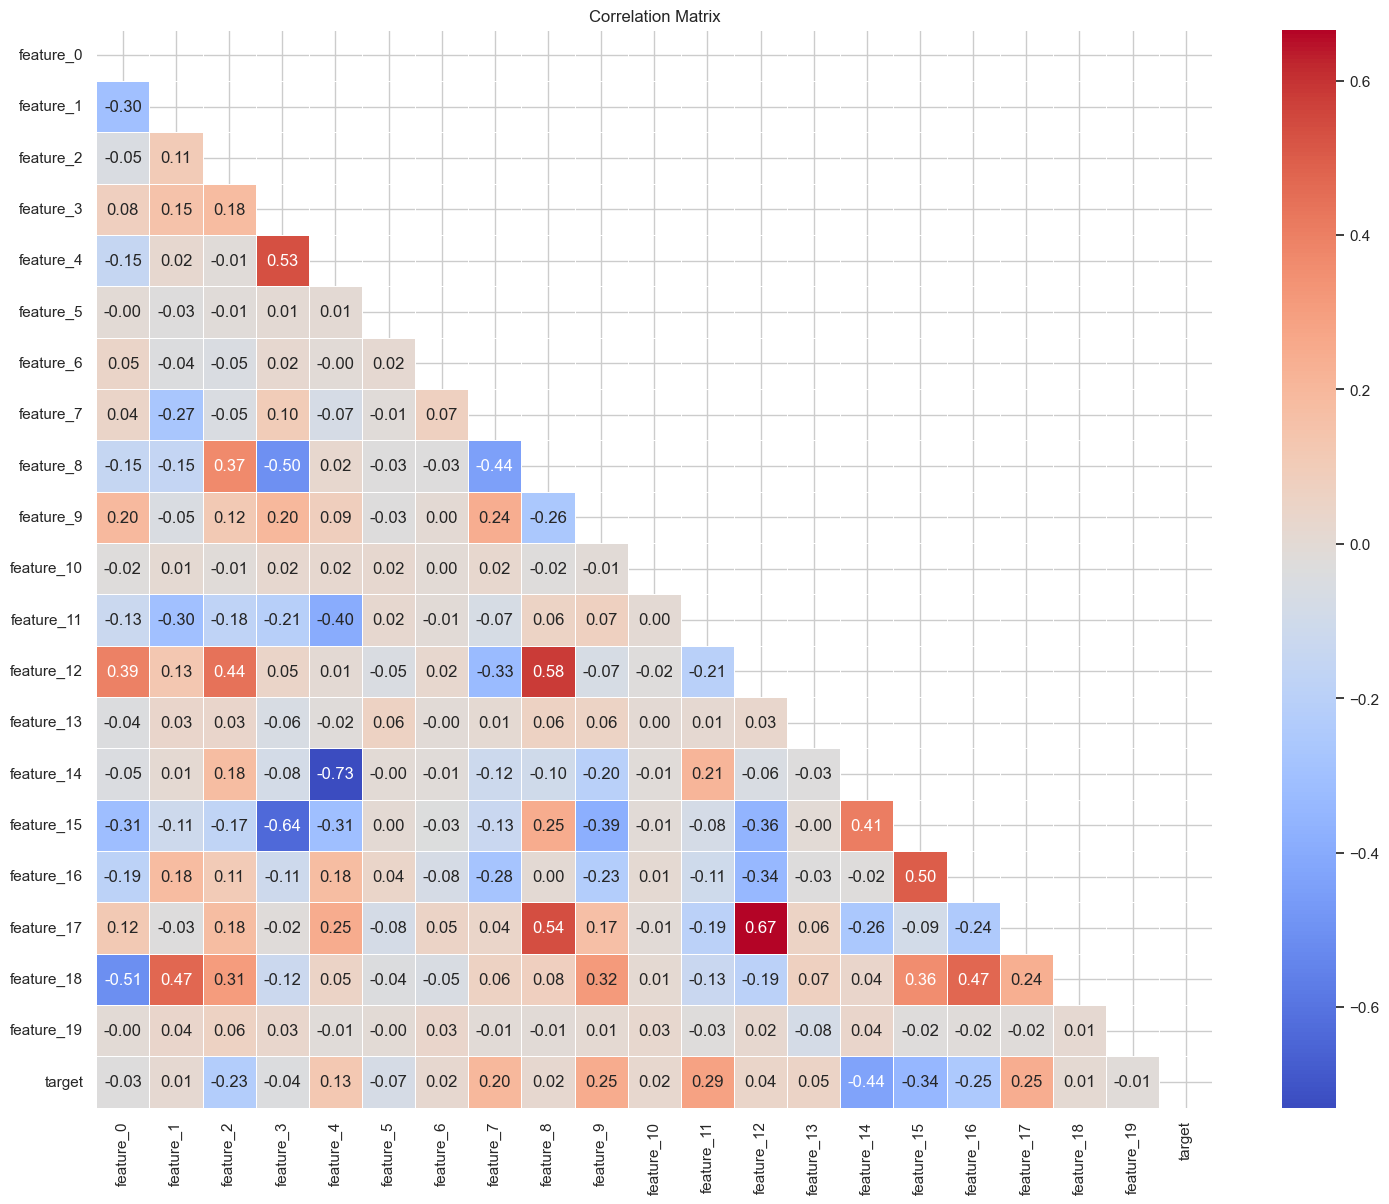

In [16]:
# 6.2 Correlation Heatmap
plt.figure(figsize=(18, 14))
corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


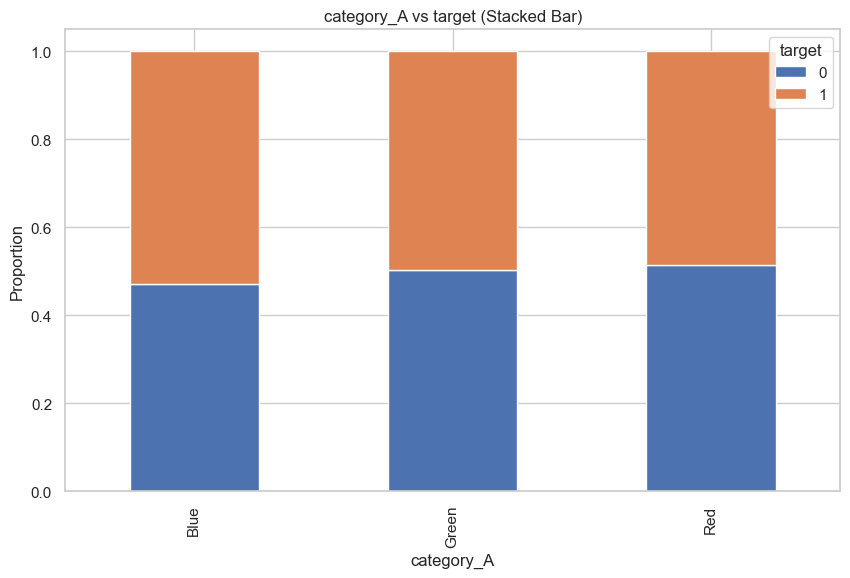

In [17]:
# 6.3 Categorical vs Target (Crosstab)
if TARGET_COL and CAT_COLS:
    cat_col = CAT_COLS[0]
    ct = pd.crosstab(df[cat_col], df[TARGET_COL], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'{cat_col} vs {TARGET_COL} (Stacked Bar)')
    plt.ylabel('Proportion')
    plt.show()
else:
    print('Skip: need TARGET_COL and at least one categorical column.')


## 7. Multivariate Analysis
Complex interactions between multiple variables.


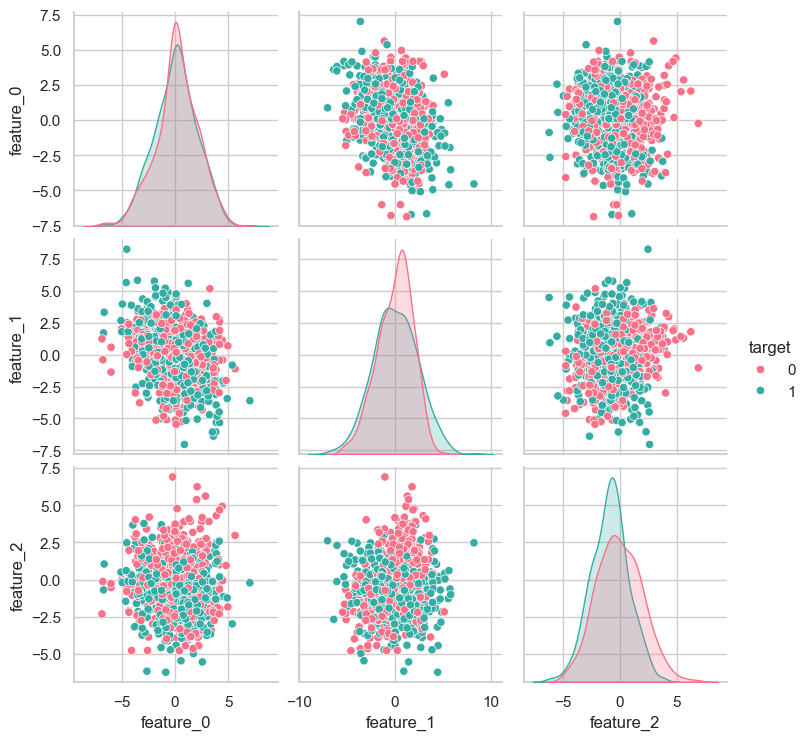

In [18]:
# 7.1 Pairplot of key features
subset_cols = NUM_COLS[:3]
if TARGET_COL and TARGET_COL in df.columns and TARGET_COL not in subset_cols:
    subset_cols.append(TARGET_COL)

if len(subset_cols) < 2:
    print('Need at least 2 columns to plot a pairplot.')
else:
    if TARGET_COL and TARGET_COL in subset_cols:
        sns.pairplot(df[subset_cols], hue=TARGET_COL, palette='husl')
    else:
        sns.pairplot(df[subset_cols])
    plt.show()


## 8. Feature Engineering
Creating new features and transforming existing ones.


In [19]:
# 8.1 Interaction Features
if len(NUM_COLS) >= 2:
    num_a, num_b = NUM_COLS[0], NUM_COLS[1]
    df[f'{num_a}_ratio_{num_b}'] = df[num_a] / (df[num_b].abs() + 1e-3)
    print(f'Created interaction feature: {num_a}_ratio_{num_b}')
else:
    print('Skip: need at least 2 numeric columns for interaction feature.')


Created interaction feature: feature_0_ratio_feature_1


In [20]:
# 8.2 Binning Numerical Variables
BINNED_COL_NAME = None
if FIRST_NUM_COL:
    BINNED_COL_NAME = f'{FIRST_NUM_COL}_binned'
    df[BINNED_COL_NAME] = pd.qcut(df[FIRST_NUM_COL], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
    print(f'Created binned feature: {BINNED_COL_NAME}')
else:
    print('Skip: need at least one numeric column for binning.')


Created binned feature: feature_0_binned


In [21]:
# 8.3 Encoding Categorical Variables
encode_cols = CAT_COLS.copy()
if BINNED_COL_NAME and BINNED_COL_NAME in df.columns:
    encode_cols.append(BINNED_COL_NAME)

if not encode_cols:
    df_encoded = df.copy()
    print('No categorical columns to encode; df_encoded is a copy of df.')
else:
    df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True)
    print(f'Performed One-Hot Encoding on: {encode_cols}')

df_encoded.head()


Performed One-Hot Encoding on: ['category_A', 'category_B', 'feature_0_binned']


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target,feature_0_ratio_feature_1,category_A_Green,category_A_Red,category_B_Low,category_B_Medium,feature_0_binned_Q2,feature_0_binned_Q3,feature_0_binned_Q4
0,0.096858,-0.360450,-0.591602,-0.728228,0.941690,1.065964,0.017832,-0.596184,1.840712,-1.497093,-1.202672,-0.603968,2.899256,0.037567,-1.249523,0.257963,0.416628,1.408208,-1.838041,-0.833142,1,0.267972,True,False,True,False,True,False,False
1,4.513369,-2.227103,-1.140747,2.018263,-2.238358,-0.497370,0.714550,0.938883,-2.395169,0.159837,0.133942,1.461499,3.954171,0.309054,0.538184,-7.157865,-4.532216,-0.081800,-9.325362,0.574386,1,2.025655,True,False,False,True,False,False,True
2,-2.355643,2.218601,-1.603269,0.873394,0.401483,0.717264,-0.859399,-1.042190,-2.175965,0.980231,1.498546,0.544434,-2.466258,-0.470256,0.073018,-2.203531,-2.299263,-1.742761,-0.271579,-0.359285,0,-1.061291,True,False,False,True,False,False,False
3,-1.596198,-0.857427,1.772434,-0.639361,1.419409,-0.438525,0.281949,2.345145,1.006230,0.389135,0.238566,-1.025051,-2.422975,1.579807,-0.300713,4.267120,2.893775,1.236697,6.034785,-0.045711,0,-1.859445,True,False,True,False,False,False,False
4,2.840049,-2.489600,-0.844902,-1.594362,-4.688517,0.459637,0.913607,-1.143505,1.263937,-2.040928,0.675664,4.176424,1.341742,0.133565,1.743819,1.531188,2.269808,0.053489,-3.151109,1.603702,0,1.140307,False,False,False,True,False,False,True


## 9. Preprocessing for Machine Learning
Scaling and Splitting the data.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separating Target and Features
if not TARGET_COL or TARGET_COL not in df_encoded.columns:
    print('Skip preprocessing: target column not set or not found in df_encoded.')
else:
    X = df_encoded.drop(TARGET_COL, axis=1)
    y = df_encoded[TARGET_COL]

    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f'Train Shape: {X_train_scaled.shape}')
    print(f'Test Shape: {X_test_scaled.shape}')


Train Shape: (800, 28)
Test Shape: (200, 28)


## 10. Practice Exercises
Try these to test your understanding.


In [ ]:
# Exercise 1: Find the feature with the highest correlation to the target (excluding itself).


In [ ]:
# Exercise 2: Create a Violin Plot for 'feature_5' against 'category_A'.


In [ ]:
# Exercise 3: Use Log Transformation on 'feature_0' and plot the before/after distribution.
